In [117]:
import pandas as pd
import lightgbm
import numpy as np
from sklearn.metrics import accuracy_score

In [168]:

def get_accuracy_assuming_dissimilarity_distance(df):
    # NOTE: unlike embeddings, a smaller value here means more likely to DIFFERENT speaker, 
    # so flipped threshold inequality
    def get_optimal_balanced_threshold(df):
        rows = []
        for i in np.arange(0, 1, 0.001):
            result = (df["dist"] < i).value_counts()
            if len(result) == 1:
                # If only True or False then its a bad threshold and move on
                continue
            ratio = result.loc[True] / result.loc[False]
            minimise_metric = abs((ratio) -1)
            rows.append({"metric": minimise_metric, "threshold":i, "ratio": ratio})
        _ = pd.DataFrame(rows)
        return _.sort_values("metric").iloc[0]
    result = get_optimal_balanced_threshold(df)
    print(result)
    df["label"] = (df["dist"] > result["threshold"]).astype(int)
    df["label"]
    accuracy = accuracy_score(df["y_comparison"], df["label"])
    print("accuracy", accuracy)
    return accuracy


In [162]:

def get_audio1_audio2_comparison_features(df_input):
    """
    Combine numerical features of audio1 and audio2 as abs(A -B)
    Combine string features of audio1 and audio2 by concatenation
    """

    df_input = pd.merge(df_input, df_features, left_on="path", right_on="filepath")
    df_input = pd.merge(df_input, df_features, left_on="audio2_path", right_on="filepath", suffixes=(None, "_audio2"))
    df_feature_columns = set(df_features.columns) - set(["Unnamed: 0", "ID", "filepath"])
    feature_type_to_columns = {}
    for i, grp in df_features[df_feature_columns].groupby(df_features.dtypes, axis=1):
        feature_type_to_columns[str(i)] = grp.columns
    df_features.dtypes
    feature_type_to_columns["object"]
    for float_column in feature_type_to_columns["float64"]:
        audio2_col = float_column + "_audio2"
        df_input.loc[:, float_column] = abs(df_input.loc[:, float_column] - df_input.loc[:, audio2_col])
        df_input.drop(audio2_col,axis=1, inplace=True)
    for str_column in feature_type_to_columns["object"]:
        audio2_col = str_column + "_audio2"
        df_input.loc[:, str_column] = df_input.loc[:, str_column] + df_input.loc[:, audio2_col]
        df_input.drop(audio2_col, axis=1, inplace=True)
    def remove_nonunique_cols(df):
        # Mutable elements need to be cast to strings in order to count unique values in that columns
        # So select all columns which are mutable
        #mutable_mask = df.applymap(lambda x: isinstance(x, dict) or isinstance(x, list)).all()
        #mutable_columns = df.columns[mutable_mask]
        ## Ah heck, just convert it all to str.
        tmp_df = df.copy()
        for col in tmp_df.columns:
            tmp_df.loc[:, col] = tmp_df.loc[:, col].astype("str")
        nunique = tmp_df.apply(pd.Series.nunique)
        cols_to_drop = nunique[nunique == 1].index
        print("dropping columns with no variation: ", cols_to_drop)
        df.drop(cols_to_drop, axis=1, inplace=True)
        return df
    for colname in feature_type_to_columns["float64"]:
        df_input.loc[:, colname] = df_input.loc[:, colname].astype("float64")
    for colname in feature_type_to_columns["object"]:
        df_input.loc[:, colname] = df_input.loc[:, colname].astype("category")
    def cast_cat_dtype_to_cat_codes(df, column_names):
        for colname in df[column_names].select_dtypes(include=['category']).columns :
            print(f"casting {colname} to category type")
            df[colname] = df[colname].cat.codes
            # Lightgbm also assumes integer casting is provided
        return df
    df_input = cast_cat_dtype_to_cat_codes(df_input, df_feature_columns)
    X = df_input[df_feature_columns]
    X = remove_nonunique_cols(X)
    Y = df_input["y_comparison"]
    # rhythm.bpm_histogram_second_peak_spread could probs be made a categorical
    return df_input, X, Y

df_features = pd.read_csv("./assets/audio_features/features_train-test-data.csv")
df_train = pd.read_csv("./notebooks/df_train.csv")
df_val = pd.read_csv("./notebooks/df_val.csv")
df_train, X_train, Y_train =  get_audio1_audio2_comparison_features(df_train)
df_val, X_val, Y_val =  get_audio1_audio2_comparison_features(df_val)

casting tonal.key_temperley.key to category type
casting tonal.chords_scale to category type
casting tonal.key_edma.key to category type
casting tonal.key_krumhansl.scale to category type
casting tonal.key_edma.scale to category type
casting tonal.key_temperley.scale to category type
casting tonal.chords_key to category type
casting tonal.key_krumhansl.key to category type
dropping columns with no variation:  Index(['lowlevel.silence_rate_20dB.mean', 'lowlevel.silence_rate_20dB.stdev'], dtype='object')


/home/ben/anaconda3/envs/pyannote/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


casting tonal.key_temperley.key to category type
casting tonal.chords_scale to category type
casting tonal.key_edma.key to category type
casting tonal.key_krumhansl.scale to category type
casting tonal.key_edma.scale to category type
casting tonal.key_temperley.scale to category type
casting tonal.chords_key to category type
casting tonal.key_krumhansl.key to category type
dropping columns with no variation:  Index(['lowlevel.silence_rate_20dB.mean', 'lowlevel.silence_rate_20dB.stdev'], dtype='object')


/home/ben/anaconda3/envs/pyannote/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [159]:
Y_train

0       False
1        True
2       False
3       False
4       False
        ...  
8528     True
8529     True
8530     True
8531     True
8532     True
Name: y_comparison, Length: 8533, dtype: bool

In [171]:
import lightgbm as lgb
param = {
    'bagging_freq': 20,          
    'bagging_fraction': 0.95,   'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.1,     'learning_rate': 0.001,
    'max_depth': -1,             'metric':'root_mean_squared_error', 'min_data_in_leaf': 5,   
       'num_leaves': 50,            
    'num_threads': 8,              'tree_learner': 'serial',   'objective': 'binary', 'metric': 'binary_logloss',
    'reg_alpha': 0.1002650970728192, 'reg_lambda': 0.1003427518866501,'verbosity': 1,
    "seed": 99999,
    "use_missing":True
}

trn_data = lgb.Dataset(X_train, label=Y_train)
val_data = lgb.Dataset(X_val, label=Y_val)
clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 20000)
# 0.264307	valid_1's binary_logloss: 0.40973 --> 0.0811523	valid_1's binary_logloss: 0.376287
# Val accuracy 0.45151515151515154
df_val["dist"] = clf.predict(X_val, num_iteration=clf.best_iteration)
accuracy = get_accuracy_assuming_dissimilarity_distance(df_val)
    

[LightGBM] [Info] Number of positive: 3951, number of negative: 4582
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27347
[LightGBM] [Info] Number of data points in the train set: 8533, number of used features: 116
Training until validation scores don't improve for 20000 rounds
[5000]	training's binary_logloss: 0.264307	valid_1's binary_logloss: 0.40973
[10000]	training's binary_logloss: 0.155829	valid_1's binary_logloss: 0.38396
[15000]	training's binary_logloss: 0.0970037	valid_1's binary_logloss: 0.376925
[20000]	training's binary_logloss: 0.0622658	valid_1's binary_logloss: 0.377162
[25000]	training's binary_logloss: 0.0408191	valid_1's binary_logloss: 0.38155
[30000]	training's binary_logloss: 0.02734	valid_1's binary_logloss: 0.388047
[35000]	training's binary_logloss: 0.0187206	valid_1's binary_logloss: 0.396207
Early stopping, best i

In [166]:
import lightgbm as lgb
param = {
        
    'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.1,     'learning_rate': 0.001,
    'max_depth': -1,             'metric':'root_mean_squared_error', 'min_data_in_leaf': 5,   
     
    'num_threads': 8,              'tree_learner': 'serial',   'objective': 'binary', 'metric': 'binary_logloss',
    'reg_alpha': 0.1002650970728192, 'reg_lambda': 0.1003427518866501,'verbosity': 1,
    "seed": 99999,
    "use_missing":True,
    "max_bin": 10,
    'bagging_fraction': 0.95, 
    'bagging_freq': 2,  
    'num_leaves': 5,       
}

trn_data = lgb.Dataset(X_train, label=Y_train)
val_data = lgb.Dataset(X_val, label=Y_val)
clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 20000)
# 0.264307	valid_1's binary_logloss: 0.40973 --> 0.0811523	valid_1's binary_logloss: 0.376287
# Val accuracy 0.45151515151515154
df_val["dist"] = clf.predict(X_val, num_iteration=clf.best_iteration)
accuracy = get_accuracy_assuming_dissimilarity_distance(df_val)
    

[LightGBM] [Info] Number of positive: 3951, number of negative: 4582
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1136
[LightGBM] [Info] Number of data points in the train set: 8533, number of used features: 116
Training until validation scores don't improve for 20000 rounds
[5000]	training's binary_logloss: 0.416209	valid_1's binary_logloss: 0.437477
[10000]	training's binary_logloss: 0.37236	valid_1's binary_logloss: 0.406085
[15000]	training's binary_logloss: 0.3502	valid_1's binary_logloss: 0.393552
[20000]	training's binary_logloss: 0.334432	valid_1's binary_logloss: 0.386978
[25000]	training's binary_logloss: 0.321246	valid_1's binary_logloss: 0.383274
[30000]	training's binary_logloss: 0.309482	valid_1's binary_logloss: 0.380889
[35000]	training's binary_logloss: 0.2986

In [175]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_val)
# I think shap_values[0] refers to all False predictions and shap_values[1] to all True predictions, or vice versa

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


AttributeError: 'list' object has no attribute 'shape'

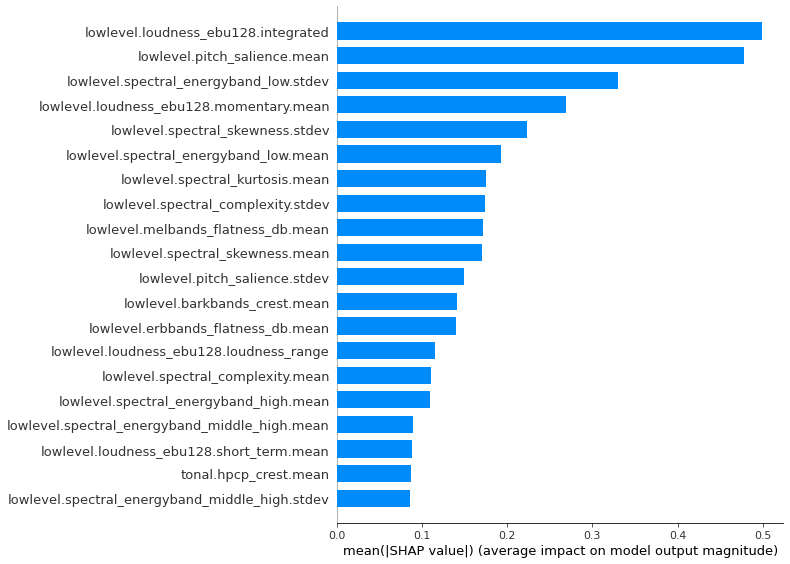

In [203]:
shap.summary_plot(shap_values[0], X_val, plot_type="bar")

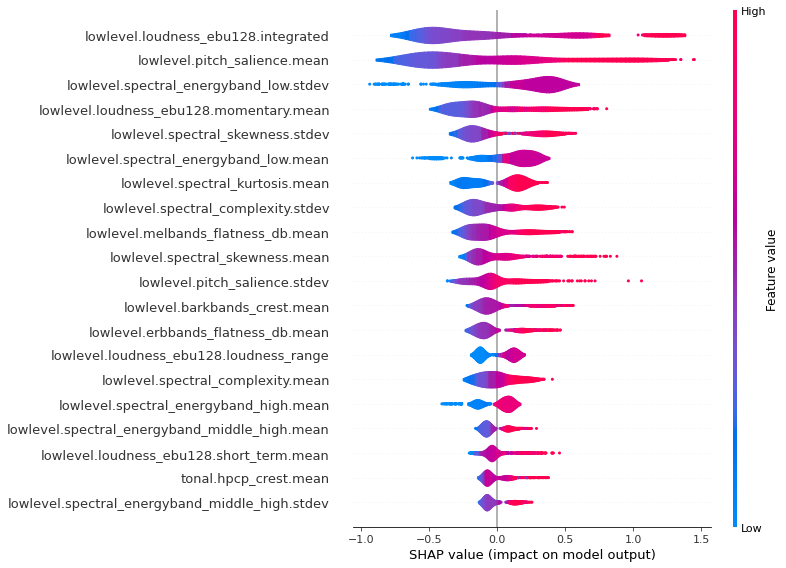

In [201]:
shap.summary_plot(shap_values[0], X_val, plot_type="violin")

In [197]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0])

In [212]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1], X_val.iloc[1])
# The diference in pitches meant they are determined to same
# Red is pushing towards being not same speaker (False) and small probability value ("dist") and the diference in loudness dominated this decision

In [210]:
df_val[["dist", "label", "y_comparison"]]

dist  label  y_comparison
0    0.383332      1         False
1    0.014844      0         False
2    0.593871      1          True
3    0.065549      0         False
4    0.735541      1          True
..        ...    ...           ...
985  0.338075      0          True
986  0.978651      1          True
987  0.947905      1          True
988  0.401000      1          True
989  0.913979      1          True

[990 rows x 3 columns]